In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = True
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

#from matplotlib import pyplot as plt
from util import util
import igraph as ig
#import numpy as np

# Constrained Optimization for Data Mining

Definitely niche, but also a great example

## Constrained Optimization for Data Mining

**Let's consider a data mining problem for web analytics**

<center><img src="assets/webdev.jpg" width="600px"/></center>

* A company wants to _analyze user behavior_ on their web site
* ...With the goal of optimizing its structure
* For privacy reason, the company _does not want to resort to tracking_
* ...And plan to relies on simple _page/link-click counts_

## Constrained Optimization for Data Mining

**Our _input_ consists of page and link _counts_ for multiple time steps**

| t | 0  | 1  | ... | 0,1 | 0,3 | 1,2 | ...  |
|:-:|:--:|:--:|:---:|:---:|:---:|:---:|:----:|
| 0 | 35 | 12 | ... | 21  | 7   |  9  | ...  |
| 1 | 42 | 14 | ... | 22  | 11  |  10 | ...  |
| 2 | 38 | 9  | ... | 17  | 10  |  8  | ...  |

* Each simple number refers to a page, each pair to a link
* Cells contain presence/link-click counts for different value of the time $t$

**Our _output_ consists of navigation paths on the web site**

A path specifies which page is visited at every point of time, e.g.:

$$
\left\{ (2, 0), (3, 0), (4, 1), (5, 3) \right\}
$$

* In this case the path starts at time $2$, stays at page $0$ for two time units
* ...Then moves to $1$ and then $3$


## Constrained Optimization for Data Mining

> **How would you tackle the problem?**

**The main issue is representing and handling _paths_**

* A path is _combinatorial_ object ($\Rightarrow$ not differentiable)
* Nodes in a path must be _connected_

In other words, the main issue is dealing with _constraints_

**We will see how to tackle the problem directly via Constrained Optimization**

* The approach will work well (though it will not be necessarily SotA)
* ...But more importantly we will see _many_ CO methods in action!


## Constrained Optimization for Data Mining

**This is a _very challenging_ problem!**

<center><img src="assets/webdev.jpg" width="600px"/></center>

* There are _many viable paths_!
* ...And we start with _quite poor information_

## Web Site as  Graph

**Our web site can be represented as a _directed graph_**

We will generate one at random, with a realistic structure 

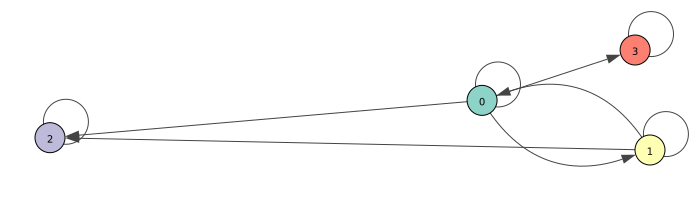

In [21]:
g = util.build_website_graph(nnodes=4, rate=3, extra_arc_fraction=0.25, seed=42)
ig.plot(g, **util.get_visual_style(g), bbox=(700, 200), margin=50)

* The method generates `nnodes` vertexes in a _tree structure_ as a base
* The #children per vertex follows a _Poisson distribution_ with specified rate
* ...Then a _fraction of the missing arcs_ is added at random

## Web Site as  Graph

**Our web site can be represented as a _directed graph_**

We will generate one at random, with a realistic structure 

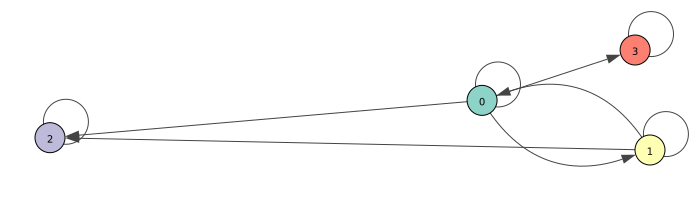

In [22]:
g = util.build_website_graph(nnodes=4, rate=3, extra_arc_fraction=0.25, seed=42)
ig.plot(g, **util.get_visual_style(g), bbox=(700, 200), margin=50)

* The graph is handled via the [python-igraph](https://igraph.org/python/) library
* ...Which provides a fast C++ implementation of many graph primitives
* The library also include a good selection of graph algorithms

## Ground Truth Generation

**We obtain realistic counts by routing "flow" along random paths**

For one path, this can be done via a function from the utility module:

In [23]:
home = g.vs[0] # Home page
eoh = 4 # End of Horizon

flow, path = util.route_random_flow(home, min_units=1, max_units=10, eoh=eoh, seed=10)
print(f'{flow:.2f}: {">".join(str(v) for v in path)}')

3.69: (1, 0)>(2, 3)>(3, 3)


* The first vertex represents the home page
* The "flow" represents the amount of users that traverse the path
* `eoh` is the number of time units over which we assume to have counts

## Ground Truth Generation

**A second function performs random routing for multiple paths**

We will start from a simple example with a very small number of paths:

In [24]:
flows, paths = util.build_random_paths(g, min_paths=3, max_paths=5,
                                          min_units=1, max_units=10, eoh=eoh, seed=10)
print('FLOW: PATH')
util.print_ground_truth(flows, paths, sort='descending')

FLOW: PATH
9.58: 3,0
5.45: 0,1 > 1,1 > 2,0 > 3,1
2.52: 1,0 > 2,0 > 3,2
1.23: 0,1 > 1,2 > 2,2 > 3,2


* Paths may start from any page
* Paths may start at any time step within the horizon

**The generated paths represent our _ground truth_**

## Time-Unfolded Graph

**Our paths may be see as traversal of a _time-unfolded_ version of the graph**

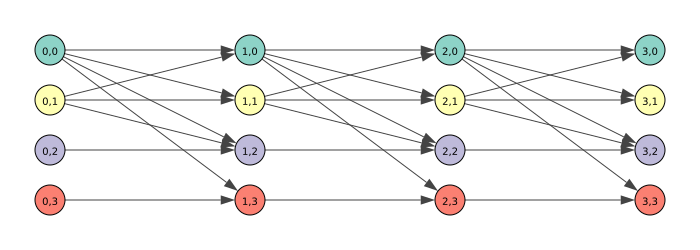

In [27]:
tug = util.build_time_unfolded_graph(g, eoh=eoh)
ig.plot(tug, **util.get_visual_style(tug), bbox=(700, 250), margin=50)

* We create `eoh` replicas of the vertexes, each referring to a specific time step
* We create `eoh` replicas of the edges, linking vertexes in adjacent time step

**This representation is referred to as _Time Unfolded Graph_**

## Computing Counts

**We can now compute counts for all vertexes and edges in the TUG**

In [28]:
node_counts, arc_counts = util.get_counts(tug, flows, paths)
print('NODE COUNTS')
print('\t'.join(f'{k}:{v:.2f}' for k, v in node_counts.items()))
print('ARC COUNTS')
print('\t'.join(f'{k}:{v:.2f}' for k, v in arc_counts.items()))

NODE COUNTS
(0, 0):0.00	(0, 1):6.68	(0, 2):0.00	(0, 3):0.00	(1, 0):2.52	(1, 1):5.45	(1, 2):1.23	(1, 3):0.00	(2, 0):7.97	(2, 1):0.00	(2, 2):1.23	(2, 3):0.00	(3, 0):9.58	(3, 1):5.45	(3, 2):3.75	(3, 3):0.00
ARC COUNTS
(1, 0, 0):0.00	(1, 0, 1):0.00	(1, 1, 1):5.45	(1, 0, 2):0.00	(1, 2, 2):0.00	(1, 0, 3):0.00	(1, 3, 3):0.00	(1, 1, 0):0.00	(1, 1, 2):1.23	(2, 0, 0):2.52	(2, 0, 1):0.00	(2, 1, 1):0.00	(2, 0, 2):0.00	(2, 2, 2):1.23	(2, 0, 3):0.00	(2, 3, 3):0.00	(2, 1, 0):5.45	(2, 1, 2):0.00	(3, 0, 0):0.00	(3, 0, 1):5.45	(3, 1, 1):0.00	(3, 0, 2):2.52	(3, 2, 2):1.23	(3, 0, 3):0.00	(3, 3, 3):0.00	(3, 1, 0):0.00	(3, 1, 2):0.00


* TUG nodes/vertexes are labeled with $(\mathit{time}, \mathit{node})$ pairs
* TUG ares are labeled with $(\mathit{time}, \mathit{source}, \mathit{destination})$ triplets

## Computing Counts

**We can inspect the arc counts visually on the TUG**

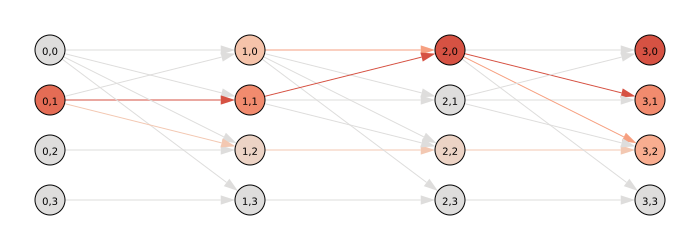

In [58]:
visual_style = util.get_visual_style(tugc, vertex_weights=node_counts, edge_weights=arc_counts)
ig.plot(tugc, **visual_style, bbox=(700, 250), margin=50)

* A grey shade corresponds to lower counts
* A red shade corresponds to higher counts

**These counts are our _available information_**

# Problem Formulation

By far the most important step of any solution process

## Problem Formulation

**Every good approach starts with a problem formulation**

* If you don't have a formulation
* Odds are that you will come up with a patched-up solution

> **Let's try to come up with a formulation for our problem!**

**We can introduce a variable $x_j$ _for each path_**

* The value of $x_j$ represents the flow associated to the path
* Then we can compute the estimated count per TUG node/arc
* ...By simply summing the $x_j$ values of paths that pass through the node/arc

## Problem Formulation

**Every good approach starts with a problem formulation**

* If you don't have a formulation
* Odds are that you will come up with a patched-up solution

> **Let's try to come up with a formulation for our problem!**

**This approach is _remarkably simple_**

* Computing counts is easy
* Connectivity constraints are safisfied by construction

**Basically, we handle some constraints _in the problem formulation_ itself**

This is a first, powerful, and underestimated method to deal with constraints 

## Path Formulation

**We will call this approch the _path formulation_**

Formally, our problem can be stated as:
$$
\arg \min_{x} \left\{\|Vx - \hat{v}\|_2^2 + \|Ex - \hat{e}\|_2^2 \mid x \geq 0 \right\}
$$

* For simplicity, here we use _linear indexes_ for TUG nodes and arcs
* $V$ is a matrix such that $V_{ij} = 1$ iff path $j$ passes through node $i$
* $E$ is a matrix such that $E_{kj} = 1$ iff path $j$ passes through arc $k$

**Path variables _cannot be negative_ (it would make no sense)**

* Hence the path formulation is itself a _constrained optimization problem_
* ...Though the constraints are in this case very simple

## Problem Reduction

**For an squared L2 norm in the form $\|Ax-b\|_2^2$ we have that:**

$$\begin{align}
\|Ax - b\|_2^2 &= (Ax - b)^T (Ax - b) \\
&= x^T A^TA x - x^T A^T b - b^T Ax + b^T b \\
&\propto \frac{1}{2} x^T (A^TA) x - \frac{1}{2} x^T A^T b - \frac{1}{2} b^T Ax \\
&= \frac{1}{2} x^T (A^TA) x + (-A^Tb)^Tx
\end{align}$$

* This is true since $x^T A^T b$ and $b^T Ax$ are scalar
* ...And $y^Tx = x^Ty$ if the quantity is a scalar
* The scaling factor $1/2$ will become convenient later

**This reduction is valid for any least squares problem**

## Problem Reduction

**We can use the relation to reduce our problem to a more compact form**

In particular, we have that:
$$
\|Vx - \hat{v}\|_2^2 + \|Ex - \hat{e}\|_2^2 \\
\propto \frac{1}{2} \|Vx - \hat{v}\|_2^2 + \frac{1}{2} \|Ex - \hat{e}\|_2^2 \\
= \frac{1}{2}x^T (V^T V) x + (-V^T \hat{v})^T x + \frac{1}{2} x^T (E^T E) x + (-E^T \hat{e})^T x \\
= \frac{1}{2} x^T P x + q^T x
$$

* Where $P = V^T V + E^T E$
* ...And $q = -V^T \hat{v} -E^T \hat{e}$

## Path Formulation as Convex Quadratic Programming

**Therefore, the path formulation can be reduced to:**

$$
\arg \min_{x} \left\{\frac{1}{2} x^T P x + q^T x \mid x \geq 0 \right\}
$$

...Which is a _quadratic program_

* I.e. a problem where we want to minimize a _quadratic form_
* ...Subject to _linear constraints_

**Our problem is also _convex_**

* This is true since $P = V^T V + E^T E$
* ...And it is therefore guaranteed semi-definite positive

**Convex quadratic programs can be solved in polynomial time**